In [1]:
import keras
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook
from utils.sentence_processor import SentenceProcessor

Using TensorFlow backend.
C:\Users\miair\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Loading train and test data

In [ ]:
reviews_test = pd.read_csv('data/reviews_test.csv', header=0, encoding='utf-8')
reviews_train = pd.read_csv('data/reviews_train.csv', header=0, encoding='utf-8')

X_train_raw = reviews_train.comment
y_train_raw = reviews_train.reting
X_test_raw = reviews_test.comment
y_test_raw = reviews_test.reting

#### Loading w2v model

In [2]:
DIR = 'data/w2v_models/'
MODEL_NAME = 'all.norm-sz100-w10-cb0-it1-min100.w2v'
VECTOR_SIZE = 100
SENTENCE_LENGTH = 100 #words

In [ ]:
w2v_path = DIR + MODEL_NAME
sentence_processor = SentenceProcessor(w2v_path)

# words with wery high freqyency in comments
garbage_list = ['я', 'большой', 'по', 'купить', 'этот', 'на', 'один', 'так', 'только', 'из', 'хороший', 'как', \
                'отличный', 'что', 'это', 'и', 'за', 'у', 'в', 'если', 'с', 'очень', 'нет', 'же', 'он', 'при', \
                'для', 'пользоваться', 'быть', 'а', 'просто', 'раз', 'работать', 'но', 'качество', 'к', 'весь',\
                'можно', 'есть', 'цена', 'от', 'уже', 'такой', 'она', 'год', 'то']

sentence_processor.stop_list = garbage_list

#### Preaparing data

In [79]:
X_train = []
y_train = []

for i in tqdm_notebook(range(len(X_train_raw))):
    sent = sentence_processor.process(X_train_raw[i])
    matrix = sentence_processor.convert2matrix(sent, sample_len=SENTENCE_LENGTH)
    if matrix.shape == (SENTENCE_LENGTH, VECTOR_SIZE):
        X_train.append(matrix)
        y_train.append(y_train_raw[i])

In [80]:
X_test = []
y_test = []
                       
for i in tqdm_notebook(range(len(X_test_raw))):
    sent = sentence_processor.process(X_test_raw[i])
    matrix = sentence_processor.convert2matrix(sent, vec_len=VECTOR_SIZE)
    if matrix.shape == (SENTENCE_LENGTH, VECTOR_SIZE):
        X_test.append(matrix)
        y_test.append(y_test_raw[i])

In [81]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [82]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_train.shape[1:] == (SENTENCE_LENGTH, VECTOR_SIZE)

(12389, 100, 100) (12389,)
(3092, 100, 100) (3092,)


In [83]:
with open('data/dataset.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)
    print ('Succesfully saved!')

Succesfully saved!


In [3]:
with open('data/dataset.pkl', 'rb') as f:
    
    X_train, y_train, X_test, y_test = pickle.load(f)
    
    assert X_train.shape[0] == y_train.shape[0]
    assert X_test.shape[0] == y_test.shape[0]
    assert X_train.shape[1:] == (SENTENCE_LENGTH, VECTOR_SIZE)
    
    print ('Succesfully loaded!')

Succesfully loaded!


### Tresting some simple regressors from the box 

#### Random forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor()

In [58]:
clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [77]:
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))
mean_squared_error(y_pred, y_test)

1.6242094975488779

#### Multi layer perceptron

In [18]:
from sklearn.neural_network import MLPRegressor

In [19]:
MLPclf = MLPRegressor(hidden_layer_sizes=(100, 80, 60,), verbose=True)

In [20]:
MLPclf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

Iteration 1, loss = 1.60724334
Iteration 2, loss = 0.72840032
Iteration 3, loss = 0.59982265
Iteration 4, loss = 0.50822482


C:\Users\miair\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 80, 60), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [23]:
y_pred = MLPclf.predict(X_test.reshape(X_test.shape[0], -1))
mean_squared_error(y_pred, y_test)

1.3828722714319823

### Playing with NN

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.preprocessing import sequence

In [5]:
# create the model
FILTER_LENGT = 32

model = Sequential()
model.add(Conv1D(input_shape=(100, 100), nb_filter=32, filter_length=FILTER_LENGT,activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Conv1D(nb_filter=16, filter_length=FILTER_LENGT/2, activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Conv1D(nb_filter=8, filter_length=FILTER_LENGT/4, activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'], learning_rate=0.001)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 69, 32)        102432      convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 34, 32)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 19.0, 16)      8208        maxpooling1d_1[0][0]             
____________________________________________________________________________________________________
maxpooling1d_2 (MaxPooling1D)    (None, 9.0, 16)       0           convolution1d_2[0][0]            
___________________________________________________________________________________________

In [92]:
model.fit(X_train, y_train, batch_size=16, nb_epoch=15, validation_data=(X_test, y_test), verbose=2)

Train on 12389 samples, validate on 3092 samples
Epoch 1/15
8s - loss: 0.4496 - mean_absolute_error: 0.4582 - acc: 0.6743 - mean_squared_error: 0.4496 - val_loss: 3.5277 - val_mean_absolute_error: 1.4817 - val_acc: 0.2717 - val_mean_squared_error: 3.5277
Epoch 2/15
8s - loss: 0.4051 - mean_absolute_error: 0.4298 - acc: 0.6930 - mean_squared_error: 0.4051 - val_loss: 1.6322 - val_mean_absolute_error: 0.8123 - val_acc: 0.5524 - val_mean_squared_error: 1.6322
Epoch 3/15
8s - loss: 0.3479 - mean_absolute_error: 0.3955 - acc: 0.7166 - mean_squared_error: 0.3479 - val_loss: 1.5319 - val_mean_absolute_error: 0.7838 - val_acc: 0.5388 - val_mean_squared_error: 1.5319
Epoch 4/15
10s - loss: 0.3005 - mean_absolute_error: 0.3594 - acc: 0.7516 - mean_squared_error: 0.3005 - val_loss: 1.4535 - val_mean_absolute_error: 0.7958 - val_acc: 0.5175 - val_mean_squared_error: 1.4535
Epoch 5/15
8s - loss: 0.2586 - mean_absolute_error: 0.3247 - acc: 0.7774 - mean_squared_error: 0.2586 - val_loss: 1.7455 - val

In [42]:
y_pred = model.predict(X_test)

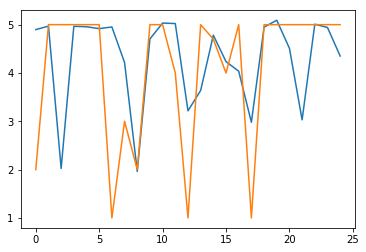

In [43]:
import matplotlib.pyplot as plt

plt.plot(y_pred[:25])
plt.plot(y_test[:25])
plt.show()

In [6]:
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from utils.layers import Attention

In [19]:
OUTPUT_DIM = 32

optimizer = keras.optimizers.SGD(momentum=0.1, nesterov=True, decay=0.1)

# create the model
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=(SENTENCE_LENGTH, VECTOR_SIZE)))
model.add(Attention(LSTM(output_dim=OUTPUT_DIM, consume_less='gpu', return_sequences=True)))
model.add(Attention(LSTM(output_dim=OUTPUT_DIM//2, consume_less='gpu')))
#model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 100, 100)      0                                            
____________________________________________________________________________________________________
attention_24 (Attention)         (None, 100, 32)       33500       input_3[0][0]                    
____________________________________________________________________________________________________
attention_25 (Attention)         (None, 16)            3680        attention_24[0][0]               
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 1)             17          attention_25[0][0]               
Total params: 37,197
Trainable params: 37,197
Non-trainable params: 0
_____________________

In [20]:
model.fit(X_train, y_train, batch_size=8, nb_epoch=15, validation_data=(X_test, y_test), verbose=2)

Train on 12389 samples, validate on 3092 samples
Epoch 1/15
1020s - loss: 1.8315 - mean_squared_error: 1.8315 - val_loss: 1.7294 - val_mean_squared_error: 1.7294
Epoch 2/15


KeyboardInterrupt: 

In [73]:
import importlib
import sentence_processor
importlib.reload(sentence_processor)

<module 'sentence_processor' from 'C:\\Users\\miair\\Documents\\Python Scripts\\MVideo\\sentence_processor.py'>